In [8]:
# ---------------------------------------------------------------
# Read nsig ± nsig_err from every ROOT file
# and store them as 'ufloat' objects
# ---------------------------------------------------------------
from pathlib import Path
import uproot
import numpy as np
from uncertainties import ufloat, unumpy as unp   # for error propagation

ROOT_DIR = Path("./FDCBpPS")   # adjust if needed

# keep only real .root files (ignore EOS version folders)
root_files = [p for p in ROOT_DIR.glob("*.root") if p.is_file()]
print(f"Processing {len(root_files)} ROOT files\n")

u_nsig = []    # one NumPy array of ufloat per file  (same order as root_files)

for fpath in root_files:
    print(f"=== {fpath.name} ===")
    with uproot.open(fpath) as rf:
        if "fit_results" not in rf:
            print("  [no TTree 'fit_results' → skipping]\n")
            continue

        tree = rf["fit_results"]

        # read the numeric branches
        arr_nsig     = tree["nsig"    ].array(library="np")
        arr_nsig_err = tree["nsig_err"].array(library="np")

        # combine value + error into one ufloat per entry
        arr_u = unp.uarray(arr_nsig, arr_nsig_err)   # vectorised creation
        u_nsig.append(arr_u)

        # pretty-print every entry
        for idx, val in enumerate(arr_u):
            print(f"  entry {idx:2d}: {val}")        # shows  1234.0+/-56.0
        print()

print("---------------------------------------------------------------")
print(f"Built list 'u_nsig'  →  len(u_nsig) = {len(u_nsig)}")
print("Each element is a NumPy array of ufloats matching that file's entries.")





Processing 127 ROOT files

=== 2024_B2CC_UP_B8_F10225.root ===
  entry  0: (1.830+/-0.029)e+04

=== 2024_B2OC_UP_B5_F10097.root ===
  entry  0: (4.543+/-0.031)e+04

=== 2024_B2CC_DOWN_B7_F10213.root ===
  entry  0: (6.28+/-0.05)e+04

=== 2024_B2CC_UP_B5_F10061.root ===
  entry  0: (2.593+/-0.030)e+04

=== 2024_B2CC_DOWN_B6_F10125.root ===
  entry  0: (7.70+/-0.05)e+04

=== 2024_B2CC_UP_B5_F10077.root ===
  entry  0: (4.86+/-0.04)e+04

=== 2024_B2CC_UP_B5_F10098.root ===
  entry  0: (2.693+/-0.030)e+04

=== 2024_B2CC_DOWN_B7_F10209.root ===
  entry  0: (1.386+/-0.025)e+04

=== 2024_B2OC_DOWN_B7_F10210.root ===
  [no TTree 'fit_results' → skipping]

=== 2024_B2OC_UP_B5_F10074.root ===
  entry  0: (4.554+/-0.031)e+04

=== 2024_B2OC_DOWN_B7_F10206.root ===
  [no TTree 'fit_results' → skipping]

=== 2024_B2CC_DOWN_B6_F10105.root ===
  entry  0: (8.46+/-0.05)e+04

=== 2024_B2OC_DOWN_B7_F10197.root ===
  [no TTree 'fit_results' → skipping]

=== 2024_B2OC_DOWN_B6_F10130.root ===
  [no TTree 'f


=== Block 5 ===
Fills: [10066, 10069, 10070, 10072, 10073, 10084, 10086, 10087, 10090, 10091, 10092, 10093, 10100]
Ratio per fill (value ±1σ):
  fill 10066:  1.142+/-0.011
  fill 10069:  0.511+/-0.006
  fill 10070:  0.1411+/-0.0034
  fill 10072:  5.21+/-0.07
  fill 10073:  2.024+/-0.022
  fill 10084:  2.536+/-0.035
  fill 10086:  4.88+/-0.08
  fill 10087:  0.2034+/-0.0027
  fill 10090:  1.786+/-0.025
  fill 10091:  0.0372+/-0.0016
  fill 10092:  1.985+/-0.020
  fill 10093:  0.635+/-0.006
  fill 10100:  2.488+/-0.033
Constant fit:  a = 0.161454 ± 0.084816
χ² = 61531.11  for 12 dof  →  χ²/ndf = 5127.59

=== Block 6 ===
Fills: [10115, 10116, 10118, 10122, 10134, 10137, 10138]
Ratio per fill (value ±1σ):
  fill 10115:  0.1385+/-0.0024
  fill 10116:  0.220+/-0.004
  fill 10118:  1.196+/-0.016
  fill 10122:  3.18+/-0.05
  fill 10134:  0.788+/-0.008
  fill 10137:  1.476+/-0.016
  fill 10138:  0.1578+/-0.0020
Constant fit:  a = 0.198036 ± 0.081219
χ² = 19942.23  for 6 dof  →  χ²/ndf = 3323.71

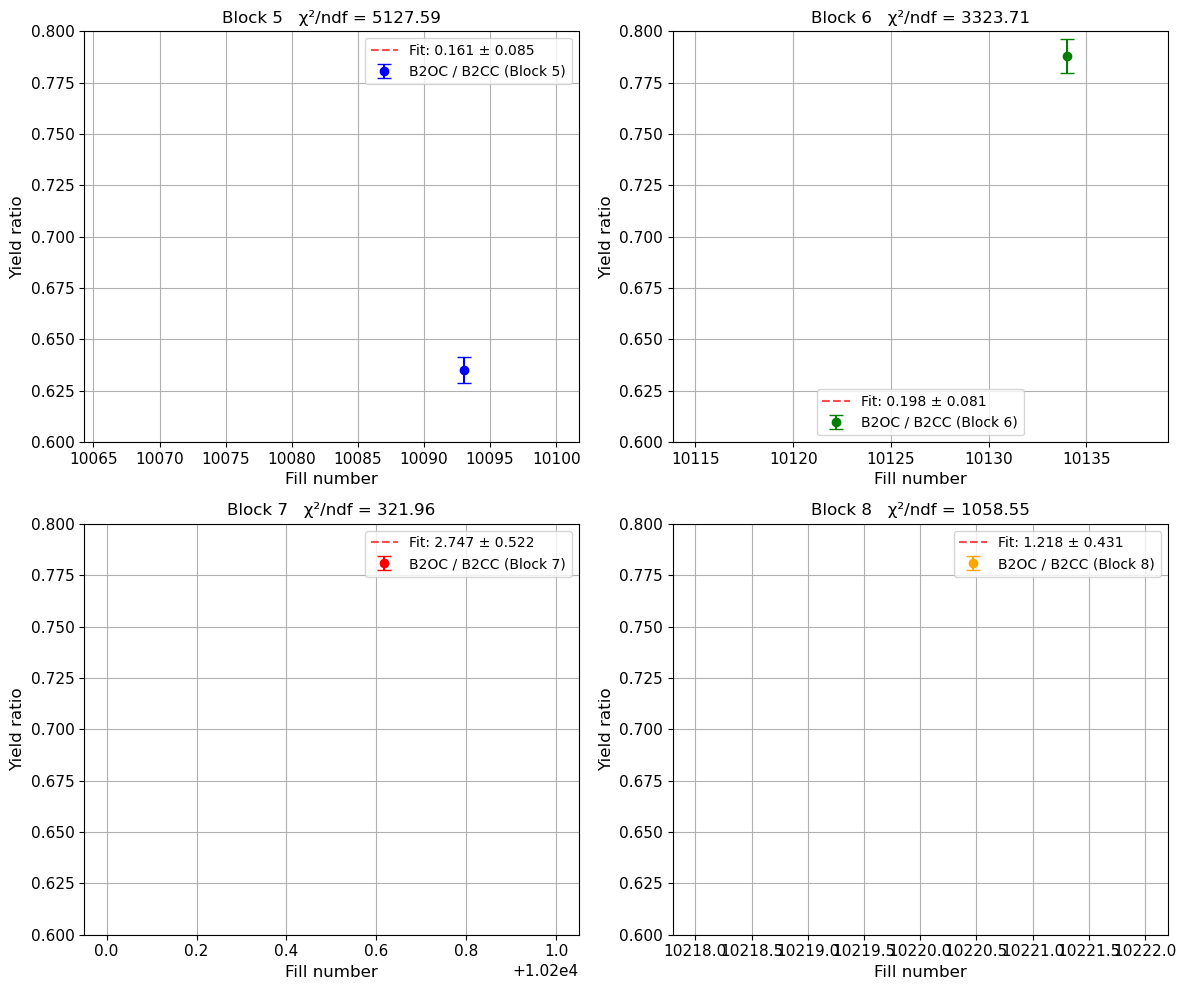

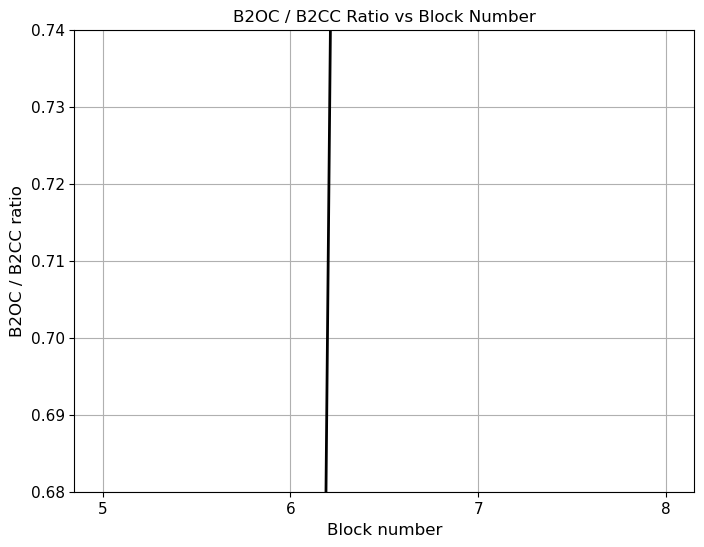


SUMMARY TABLE: B2OC / B2CC Ratios by Block
Block  Ratio        Error        χ²/ndf   Fills
------------------------------------------------------------
5      0.161454     0.084816     5127.59  [10066, 10069, 10070, 10072, 10073, 10084, 10086, 10087, 10090, 10091, 10092, 10093, 10100]
6      0.198036     0.081219     3323.71  [10115, 10116, 10118, 10122, 10134, 10137, 10138]
7      2.747286     0.522092     321.96   [10200, 10201]
8      1.217913     0.431208     1058.55  [10218, 10219, 10222]

Overall stability:
Mean ratio across blocks: 1.081172
Standard deviation: 1.213870
Relative variation: 112.274%


In [10]:
# ---------------------------------------------------------------
# Plot B2OC / B2CC yield ratio for ALL blocks (5, 6, 7, 8)
# ---------------------------------------------------------------
import re
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from scipy.optimize import curve_fit

# 1) Gather total nsig per (campaign, block, fill)
tot = {"B2OC": {}, "B2CC": {}}
blocks = [5, 6, 7, 8]

for block in blocks:
    tot["B2OC"][block] = {}
    tot["B2CC"][block] = {}

for path, arr_u in zip(root_files, u_nsig):
    fname = path.name.upper()

    # extract block number
    block_match = re.search(r"_B(\d+)_", fname)
    if not block_match:
        continue
    block = int(block_match.group(1))
    
    # only process blocks 5, 6, 7, 8
    if block not in blocks:
        continue

    # campaign tag
    if   "B2OC" in fname:
        camp = "B2OC"
    elif "B2CC" in fname:
        camp = "B2CC"
    else:
        continue

    # extract fill number, e.g. "…_F10059"
    fill_match = re.search(r"_F(\d+)", fname)
    if not fill_match:
        continue
    fill = int(fill_match.group(1))

    # total yield in this file (value + error propagate)
    tot[camp][block][fill] = arr_u.sum()

# 2) Plot each block separately
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

block_colors = ['blue', 'green', 'red', 'orange']
all_fits = {}

for i, block in enumerate(blocks):
    ax = axes[i]
    
    # Build ratios for fills that appear in *both* campaigns for this block
    fills = sorted(set(tot["B2OC"][block]) & set(tot["B2CC"][block]))
    
    if len(fills) == 0:
        ax.text(0.5, 0.5, f"No common fills\nfor Block {block}", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"Block {block}")
        continue
    
    rat_u = [tot["B2OC"][block][f] / tot["B2CC"][block][f] for f in fills]
    rat_val = unp.nominal_values(rat_u)
    rat_err = unp.std_devs(rat_u)
    
    # Plot
    ax.errorbar(fills, rat_val, yerr=rat_err, fmt='o', capsize=5,
                color=block_colors[i], ecolor=block_colors[i], 
                label=f'B2OC / B2CC (Block {block})')
    ax.set_xlabel("Fill number")
    ax.set_ylabel("Yield ratio")
    ax.set_ylim(0.60, 0.80) 
    ax.grid(True)
    
    # Fit to a constant
    def const(x, a): return a
    if len(fills) > 1:
        popt, pcov = curve_fit(const, fills, rat_val, sigma=rat_err)
        a_fit = popt[0]
        sig_a = np.sqrt(pcov[0,0])
        
        chi2 = np.sum(((rat_val - a_fit)/rat_err)**2)
        chi2rd = chi2 / (len(fills) - 1) if len(fills) > 1 else 0
        
        ax.axhline(a_fit, color='red', linestyle='--', alpha=0.7,
                   label=f"Fit: {a_fit:.3f} ± {sig_a:.3f}")
        ax.set_title(f"Block {block}   χ²/ndf = {chi2rd:.2f}")
        
        all_fits[block] = {'ratio': a_fit, 'error': sig_a, 'chi2rd': chi2rd, 'fills': fills}
    else:
        ax.set_title(f"Block {block} (single fill)")
        all_fits[block] = {'ratio': rat_val[0], 'error': rat_err[0], 'chi2rd': 0, 'fills': fills}
    
    ax.legend()
    
    # Print numerical results for this block
    print(f"\n=== Block {block} ===")
    print(f"Fills: {fills}")
    print("Ratio per fill (value ±1σ):")
    for f, r in zip(fills, rat_u):
        print(f"  fill {f}:  {r}")
    
    if len(fills) > 1:
        print(f"Constant fit:  a = {a_fit:.6f} ± {sig_a:.6f}")
        print(f"χ² = {chi2:.2f}  for {len(fills)-1} dof  →  χ²/ndf = {chi2rd:.2f}")

plt.tight_layout()
plt.show()

# 3) Summary plot: Compare fitted ratios across blocks
plt.figure(figsize=(8, 6))
block_nums = []
block_ratios = []
block_errors = []

for block in blocks:
    if block in all_fits:
        block_nums.append(block)
        block_ratios.append(all_fits[block]['ratio'])
        block_errors.append(all_fits[block]['error'])

plt.errorbar(block_nums, block_ratios, yerr=block_errors, fmt='o-', capsize=5,
             color='black', ecolor='black', linewidth=2, markersize=8)
plt.xlabel("Block number")
plt.ylabel("B2OC / B2CC ratio")
plt.ylim(0.68, 0.74)
plt.title("B2OC / B2CC Ratio vs Block Number")
plt.grid(True)
plt.xticks(blocks)

# Add text annotations with chi2/ndf
for block, ratio, error in zip(block_nums, block_ratios, block_errors):
    chi2rd = all_fits[block]['chi2rd']
    plt.annotate(f'χ²/ndf = {chi2rd:.2f}', 
                xy=(block, ratio), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)

plt.show()

# 4) Print summary table
print("\n" + "="*60)
print("SUMMARY TABLE: B2OC / B2CC Ratios by Block")
print("="*60)
print(f"{'Block':<6} {'Ratio':<12} {'Error':<12} {'χ²/ndf':<8} {'Fills'}")
print("-"*60)
for block in blocks:
    if block in all_fits:
        fit = all_fits[block]
        fills_str = str(fit['fills'])
        print(f"{block:<6} {fit['ratio']:<12.6f} {fit['error']:<12.6f} {fit['chi2rd']:<8.2f} {fills_str}")
    else:
        print(f"{block:<6} {'No data':<12} {'---':<12} {'---':<8} {'[]'}")

# 5) Overall stability check
if len(block_ratios) > 1:
    overall_mean = np.mean(block_ratios)
    overall_std = np.std(block_ratios, ddof=1)
    print(f"\nOverall stability:")
    print(f"Mean ratio across blocks: {overall_mean:.6f}")
    print(f"Standard deviation: {overall_std:.6f}")
    print(f"Relative variation: {(overall_std/overall_mean)*100:.3f}%")

In [5]:
# ---------------------------------------------------------------
# Diagnostic: Check error propagation and identify large uncertainties
# ---------------------------------------------------------------

print("DIAGNOSTIC: Error Propagation Analysis")
print("="*60)

# Re-examine the data with detailed error breakdown
for path, arr_u in zip(root_files, u_nsig):
    fname = path.name.upper()
    
    # extract block and fill
    block_match = re.search(r"_B(\d+)_", fname)
    fill_match = re.search(r"_F(\d+)", fname)
    
    if not block_match or not fill_match:
        continue
        
    block = int(block_match.group(1))
    fill = int(fill_match.group(1))
    
    if block not in [5, 6, 7, 8]:
        continue
    
    # Check if this file has unusually large errors
    if len(arr_u) > 0:
        total_yield = arr_u.sum()
        individual_errors = [val.std_dev for val in arr_u]
        max_individual_error = max(individual_errors) if individual_errors else 0
        
        # Flag files with suspiciously large errors
        relative_error = total_yield.std_dev / total_yield.nominal_value if total_yield.nominal_value > 0 else float('inf')
        
        print(f"\nFile: {fname}")
        print(f"  Block {block}, Fill {fill}")
        print(f"  Total yield: {total_yield}")
        print(f"  Relative error: {relative_error*100:.2f}%")
        print(f"  Max individual error: {max_individual_error:.1f}")
        print(f"  Number of entries: {len(arr_u)}")
        
        # Detailed breakdown for suspicious cases
        if relative_error > 0.5:  # More than 50% relative error
            print(f"  ⚠️  WARNING: Very large relative error!")
            print(f"  Individual yields:")
            for i, val in enumerate(arr_u):
                print(f"    Entry {i}: {val}")
        
        if len(arr_u) == 1 and individual_errors[0] > 100:  # Large absolute error
            print(f"  ⚠️  WARNING: Single entry with large absolute error!")

print("\n" + "="*60)
print("ERROR PROPAGATION FORMULA CHECK:")
print("="*60)
print("For ratio R = A/B, the propagated error is:")
print("σ_R = R * sqrt((σ_A/A)² + (σ_B/B)²)")
print("")
print("Potential issues:")
print("1. Small denominators → large relative errors")
print("2. Failed fits → unrealistic error estimates") 
print("3. Single entry files → no cross-check possible")
print("4. Systematic underestimation of fit errors")

# Let's also check the actual ratio calculations for problematic cases
print("\n" + "="*60)
print("RATIO CALCULATION VERIFICATION:")
print("="*60)

for block in [5, 6]:  # Focus on blocks that might have issues
    print(f"\n=== Block {block} Details ===")
    
    b2oc_data = tot["B2OC"].get(block, {})
    b2cc_data = tot["B2CC"].get(block, {})
    
    common_fills = sorted(set(b2oc_data.keys()) & set(b2cc_data.keys()))
    
    for fill in common_fills:
        b2oc_val = b2oc_data[fill]
        b2cc_val = b2cc_data[fill]
        ratio = b2oc_val / b2cc_val
        
        print(f"  Fill {fill}:")
        print(f"    B2OC: {b2oc_val}")
        print(f"    B2CC: {b2cc_val}")
        print(f"    Ratio: {ratio}")
        print(f"    Relative errors: B2OC={b2oc_val.std_dev/b2oc_val.nominal_value*100:.1f}%, B2CC={b2cc_val.std_dev/b2cc_val.nominal_value*100:.1f}%")
        
        # Manual error propagation check
        rel_err_a = b2oc_val.std_dev / b2oc_val.nominal_value
        rel_err_b = b2cc_val.std_dev / b2cc_val.nominal_value
        expected_rel_err = np.sqrt(rel_err_a**2 + rel_err_b**2)
        expected_abs_err = (b2oc_val.nominal_value / b2cc_val.nominal_value) * expected_rel_err
        
        print(f"    Expected ratio error: {expected_abs_err:.6f}")
        print(f"    Actual ratio error: {ratio.std_dev:.6f}")
        print(f"    Match: {'✓' if abs(expected_abs_err - ratio.std_dev) < 1e-10 else '✗'}")

DIAGNOSTIC: Error Propagation Analysis

File: 2024_B2CC_DOWN_B6_F10104.ROOT
  Block 6, Fill 10104
  Total yield: (6.8+/-0.4)e+03
  Relative error: 5.34%
  Max individual error: 365.1
  Number of entries: 1
  ⚠️  WARNING: Single entry with large absolute error!

File: 2024_B2CC_DOWN_B6_F10105.ROOT
  Block 6, Fill 10105
  Total yield: (9.12+/-0.07)e+04
  Relative error: 0.75%
  Max individual error: 681.4
  Number of entries: 1
  ⚠️  WARNING: Single entry with large absolute error!

File: 2024_B2CC_DOWN_B6_F10107.ROOT
  Block 6, Fill 10107
  Total yield: (8.29+/-0.11)e+04
  Relative error: 1.37%
  Max individual error: 1135.3
  Number of entries: 1
  ⚠️  WARNING: Single entry with large absolute error!

File: 2024_B2CC_DOWN_B6_F10112.ROOT
  Block 6, Fill 10112
  Total yield: (4.40+/-0.05)e+04
  Relative error: 1.08%
  Max individual error: 476.2
  Number of entries: 1
  ⚠️  WARNING: Single entry with large absolute error!

File: 2024_B2CC_DOWN_B6_F10115.ROOT
  Block 6, Fill 10115
  Total

In [ ]:
# ---------------------------------------------------------------
# Simple File Browser: Just iterate through files with a number
# ---------------------------------------------------------------
import ROOT as r
from pathlib import Path


#file_num = 110



# Set your starting file number here (change this to start from any file)
if 'file_num' not in globals():
    file_num = 1  # Start from file 1

# Get all ROOT files
root_files = sorted([f for f in Path(".").glob("*.root") if f.is_file()])

print(f"Found {len(root_files)} files")
print(f"Current file_num = {file_num}")

# Make sure file_num is valid
if file_num > len(root_files):
    file_num = 1
    print(f"Wrapped back to file 1")

# Get current file (convert to 0-based index)
current_file = root_files[file_num - 1]
print(f"Plotting file {file_num}: {current_file.name}")

# Open file and plot canvas
file = r.TFile.Open(str(current_file))

# Find the canvas
canvas = None
for key in file.GetListOfKeys():
    obj_name = key.GetName()
    if "_mass_fit_block" in obj_name and "_fill" in obj_name and "_log" in obj_name:
        canvas = file.Get(obj_name)
        print(f"Found canvas: {obj_name}")
        break

if canvas:
    canvas.Draw()
    canvas.Update()
    print("Canvas displayed!")
else:
    print("No canvas found")

file.Close()

# Increase for next time
file_num += 1
print(f"Next run will show file {file_num}")

# To go to a specific file, just change file_num at the top
print("\nTip: To jump to a specific file, run: file_num = 5 (then run this cell)")

Found 132 files
Current file_num = 1
Plotting file 1: 2024_B2CC_DOWN_B6.root
Found canvas: jpsik_mass_fit_block6_fillNone_log
Canvas displayed!
Next run will show file 2

Tip: To jump to a specific file, run: file_num = 5 (then run this cell)


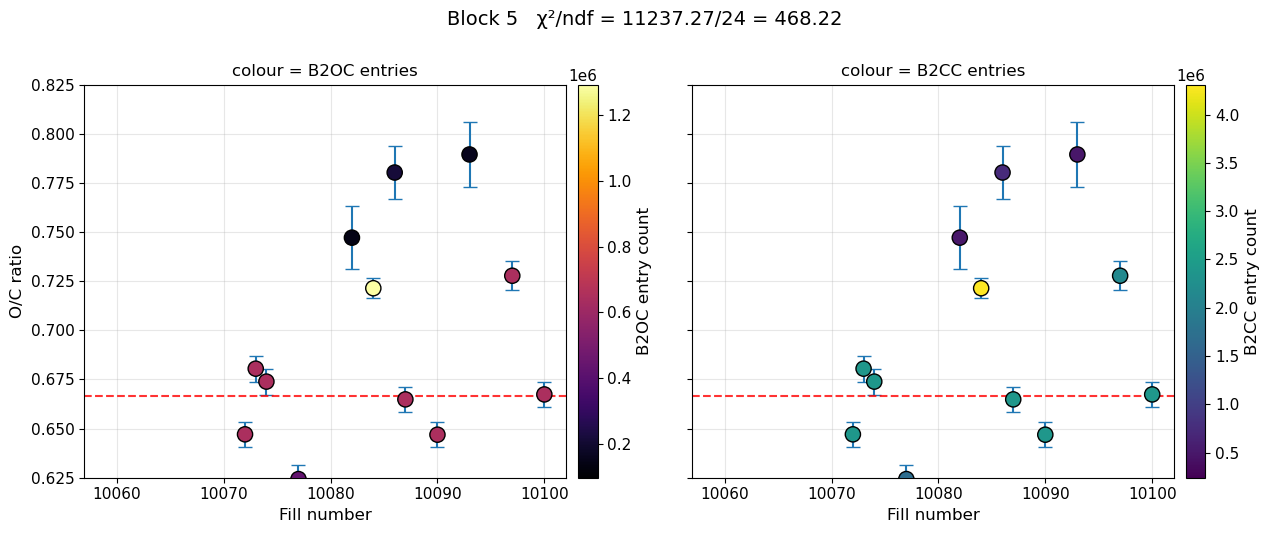

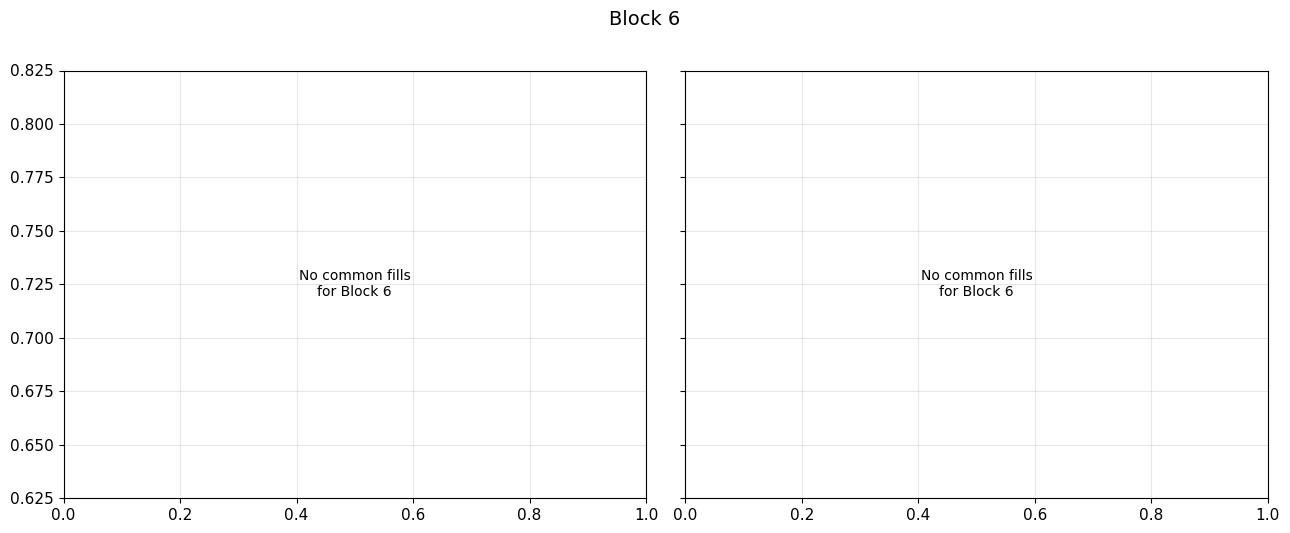

In [11]:
# ---------------------------------------------------------------
# Blocks 5 & 6 only — O/C ratio vs fill
# Left panel: colour = B2OC entry count  |  Right: colour = B2CC entry count
# Title: Block X   χ²/ndf = <chi2>/<ndf> = <ratio>
# ---------------------------------------------------------------
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from scipy.optimize import curve_fit
import uproot

# ----------- settings -----------
ROOT_DIR = Path("./FDCBpPS")
blocks_to_plot = [5, 6]
ymin, ymax = 0.625, 0.825   # slide-like y-range
point_size = 120
# --------------------------------

# 1) build (path, nsig±err) list ONLY for files that have fit_results
pairs = []
for fpath in sorted(p for p in ROOT_DIR.glob("*.root") if p.is_file()):
    try:
        with uproot.open(fpath) as rf:
            if "fit_results" not in rf:
                continue
            tr = rf["fit_results"]
            nsig     = tr["nsig"    ].array(library="np")
            nsig_err = tr["nsig_err"].array(library="np")
            pairs.append((fpath, unp.uarray(nsig, nsig_err)))
    except Exception:
        continue

# 2) collect totals and entry counts per (campaign, block, fill)
tot = {"B2OC": {b:{} for b in blocks_to_plot}, "B2CC": {b:{} for b in blocks_to_plot}}
nentries = {"B2OC": {b:{} for b in blocks_to_plot}, "B2CC": {b:{} for b in blocks_to_plot}}

re_block = re.compile(r"_B(\d+)_", re.IGNORECASE)
re_fill  = re.compile(r"_F(\d+)",   re.IGNORECASE)

for fpath, arr_u in pairs:
    fname = fpath.name.upper()
    mB = re_block.search(fname);  mF = re_fill.search(fname)
    if not (mB and mF): 
        continue
    block = int(mB.group(1)); fill = int(mF.group(1))
    if block not in blocks_to_plot:
        continue

    if   "B2OC" in fname: camp, treename = "B2OC", "ST-b2oc"
    elif "B2CC" in fname: camp, treename = "B2CC", "ST-b2cc"
    else: continue

    tot[camp][block][fill] = arr_u.sum()

    # read entry count for heat colour
    try:
        with uproot.open(fpath) as rf:
            nentries[camp][block][fill] = int(rf[treename].num_entries) if treename in rf else np.nan
    except Exception:
        nentries[camp][block][fill] = np.nan

# 3) plotting helper for one block
def plot_block(block):
    fills = sorted(set(tot["B2OC"][block]) & set(tot["B2CC"][block]))
    fig, axs = plt.subplots(1, 2, figsize=(13, 5.5), sharey=True)
    axs = axs.ravel()

    title_text = f"Block {block}"
    if len(fills) >= 1:
        rat_u   = [tot["B2OC"][block][f] / tot["B2CC"][block][f] for f in fills]
        rat_val = unp.nominal_values(rat_u).astype(float)
        rat_err = unp.std_devs(rat_u).astype(float)

        # clean bad points (nan or zero error)
        mask = np.isfinite(rat_val) & np.isfinite(rat_err) & (rat_err > 0)
        fills = np.array(fills)[mask]; rat_val = rat_val[mask]; rat_err = rat_err[mask]

        a_fit, sig_a, chi2, ndf = np.nan, np.nan, 0.0, 0
        if len(fills) > 1:
            def const(x, a): return a
            popt, pcov = curve_fit(const, fills.astype(float), rat_val, sigma=rat_err, absolute_sigma=False)
            a_fit = float(popt[0])
            sig_a = float(np.sqrt(pcov[0,0])) if pcov.size else np.nan
            chi2  = float(np.sum(((rat_val - a_fit)/rat_err)**2))
            ndf   = len(fills) - 1
            chi2rd = chi2/ndf if ndf>0 else 0.0
            title_text = f"Block {block}   χ²/ndf = {chi2:.2f}/{ndf} = {chi2rd:.2f}"
        else:
            title_text = f"Block {block} (single fill)"

        # Left: colour = B2OC entries
        ax = axs[0]
        ax.errorbar(fills, rat_val, yerr=rat_err, fmt='o', capsize=5,
                    color='tab:blue', ecolor='tab:blue', label=f"B2OC / B2CC (Block {block})")
        heat_oc = np.array([nentries["B2OC"][block].get(int(f), np.nan) for f in fills])
        sc1 = ax.scatter(fills, rat_val, c=heat_oc, s=point_size, edgecolors='k', cmap='inferno', zorder=3)
        if ndf>0: ax.axhline(a_fit, ls='--', color='red', alpha=0.8)
        ax.set_title("colour = B2OC entries")
        ax.set_xlabel("Fill number"); ax.set_ylabel("O/C ratio")
        ax.set_ylim(ymin, ymax); ax.grid(True, alpha=0.3)
        cb1 = fig.colorbar(sc1, ax=ax, pad=0.02); cb1.set_label("B2OC entry count")

        # Right: colour = B2CC entries
        ax = axs[1]
        ax.errorbar(fills, rat_val, yerr=rat_err, fmt='o', capsize=5,
                    color='tab:blue', ecolor='tab:blue')
        heat_cc = np.array([nentries["B2CC"][block].get(int(f), np.nan) for f in fills])
        sc2 = ax.scatter(fills, rat_val, c=heat_cc, s=point_size, edgecolors='k', cmap='viridis', zorder=3)
        if ndf>0: ax.axhline(a_fit, ls='--', color='red', alpha=0.8)
        ax.set_title("colour = B2CC entries")
        ax.set_xlabel("Fill number")
        ax.set_ylim(ymin, ymax); ax.grid(True, alpha=0.3)
        cb2 = fig.colorbar(sc2, ax=ax, pad=0.02); cb2.set_label("B2CC entry count")

    else:
        # no common fills
        for j, ax in enumerate(axs):
            ax.text(0.5, 0.5, f"No common fills\nfor Block {block}",
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_ylim(ymin, ymax); ax.grid(True, alpha=0.3)
            ax.set_title("")

    fig.suptitle(title_text, y=0.96, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 4) draw the two blocks
plot_block(5)
plot_block(6)
